In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### There are various package to do ML.

I'm using TensorFlow, which is I think the easiest (not necessarily the best regarding comprehension and debugging) https://www.tensorflow.org/

For more lowlevel, you can use Torch (or PyTorch). 

For Bayesian models, or when you want to do complex stuff regarding gradient descent, matrix incersion or else, (or even more classic ML), the one who's groing a lot these days is JaX (https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)



In [2]:
import tensorflow as tf

2023-09-06 11:59:11.048470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


I'm also using a lot a subpackage of tf, called Keras (it was previously two different package, with tf being lower level API and Keras being very user freidnly, but they merged in tensorflow 2.1). It's the easiest API to use, and you can even do complex things. This is what I use the most. Nevertheless, if you want to really understand what is going on, it's good to start learning with pure tensorflow, where you define more what you're doing. 

You can also use a bit of both now that it's the same IPA, and take the best of both worlds! That what we will be doing here

In [3]:
from tensorflow import keras as tfk

## The Problem

Let's define a very simple task : fit a linear problem.

We have slope, $a=1$, and an intercept $b=-1$. Our data points, {$y_i$} follow $y_i=ax_i+b$, where {$x_i$} range from $0$ to $4$.

To make the task a bit harder, we add a white noise of dispersion $\sigma=0.2$

In [4]:
a, b = 2, 5 #0.9, 0.2
sigma = 0.01

xs = np.linspace(0.2, 0.8, 1000)

rdms = 0#np.random.normal(0, sigma, len(xs))
ys = (a * xs + b + rdms)

Text(0.5, 1.0, 'Training data')

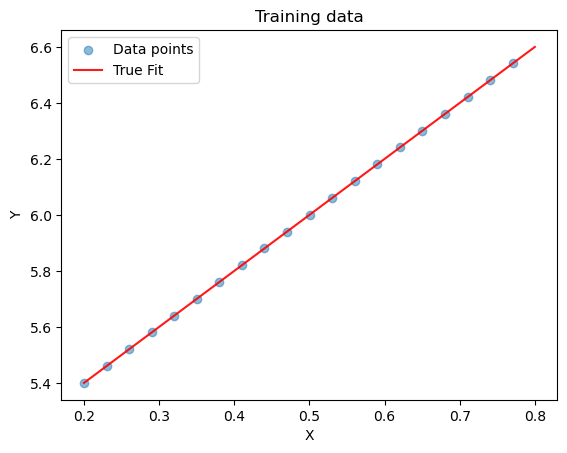

In [5]:
plt.scatter(xs[::50], ys[::50], alpha=0.5, label='Data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot([xs[0], xs[-1]], [a*xs[0]+b, a*xs[-1]+b], alpha=0.9, label='True Fit', color='red')
plt.legend()
plt.title('Training data')

Now, let's prepare our data to work with a simple neural network :
- Randomize the data points
- Group them in batches
- Add a feature layer to store the ground truth (i.e. add the corresponding _y_ to each _x_)

In [6]:
random.Random(4).shuffle(xs)
random.Random(4).shuffle(ys)
print('x shape: ', xs.shape, 'y shape', ys.shape)

batch_size = 64
nb_batch_train = int((0.8*len(xs)) // batch_size)
# nb_batch_test = int((0.2*len(xs)) // batch_size)
print('number of batches for training:', nb_batch_train)
X_train = np.zeros((nb_batch_train, batch_size))
Y_train = np.zeros((nb_batch_train, batch_size))

for i in range(nb_batch_train):
    X_train[i, :] = xs[i*batch_size: (i+1)*batch_size]
    Y_train[i, :] = ys[i*batch_size: (i+1)*batch_size]

print('Final shape of the training set', X_train.shape)

x shape:  (1000,) y shape (1000,)
number of batches for training: 12
Final shape of the training set (12, 64)


We can know define our model : we just have one dense layer of one weight, $w_1$, and a bias vector of one number, $b_1$. By doing that, our network is doing exactly a linear model : the output of a input point $x_i$ is 

$y_i = w_1x_i + b_1$.

Thus, fitting $w_1$ and $b_1$ by gradient descent will approximate the true $a$ and $b$ where our data point come from.

We initiate our values with wrong value : let's suppose that $a=-1$ and $b=2$.

In [21]:
a_init, b_init = 1.9, 4
# as_pred = [a_init]
# bs_pred = [b_init]
X_in = tfk.Input(shape=(1), dtype=tf.float32)
# Y_out = tfk.layers.Dense(1, kernel_initializer=tfk.initializers.Constant(
#     value=a_init), bias_initializer=tfk.initializers.Constant(
#     value=b_init))(X_in)
Y_out = tfk.layers.Dense(1)(X_in)


model = tfk.Model(inputs=X_in, outputs=Y_out, name='model')

In [22]:
model(np.ones((1, 1))).numpy()

array([[5.9]], dtype=float32)

Note how we defined our model with Keras: 
- Define the Input, with the shape being only the shape of a single data point (here it's thus simply 1, but if you were working with a spectra it would be the number of points in your spectra, or if it was an image it would be the shape of the image, e.g. (128, 128) or (128, 128, 3) if it's a color image.)
- Create your architecture by applying a tensorflow.keras layer (here it's just a Dense Neurone, but could be a convolution, or everything you want, see https://www.tensorflow.org/api_docs/python/tf/keras/layers to see the huge amount of layers implemented in tfk.)
- Define your model with the `Model` API, which will allow you a lot of nice and easy manipulation of your architecture. You should just define what's the input, and what is the output. The other *hyperparameters* such as the loss, the learning rate etc will be defined in your training function

See what your model looks like with the nice `summary()` method:

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Note the `None` in the shape: tfk models automatically create another dimension in your data to work with batch, but is flexible in the size of the batch!

We can also plot the model:

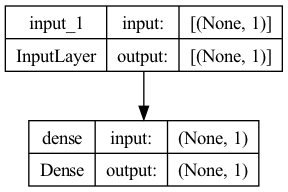

In [10]:
tfk.utils.plot_model(model, 'single_neuron.png', show_shapes=True)

In [11]:
# model.compile('rmsprop', tf.keras.losses.MSE)
# hist = model.fit(xs, ys, 32, 100)

Now, we can define our training step function (you can check the `model.fit()` [https://keras.io/api/models/model_training_apis/#fit-method] API for a higher evel API, but I don't really like it as you really don't manage much yourself):

In [12]:
def train_model(X, Y):#, loss_fn, optimizer):
    """ with this, tf will automatically record al the info to then compute all gradients and then more the weights with gradient descent """
    with tf.GradientTape() as tape: 
        pred = model(X)
        # loss = tf.reduce_mean((Y - pred)**2)
        loss = tf.reduce_mean(tfk.losses.MSE(Y, pred))
        # loss = tf.reduce_mean(loss_fn(Y, pred))
    manual_output = model.weights[0].numpy()[0][0] * X + model.weights[1].numpy()[0]
    manual_loss = tf.reduce_mean(tfk.losses.MSE(Y, manual_output))
    # manual_loss = tf.reduce_mean(tf.square(tf.subtract(manual_output, Y)))
    gradients = tape.gradient(loss, model.trainable_variables)
    tf.keras.optimizers.RMSprop(0.001).apply_gradients(zip(gradients, model.trainable_variables))
    a_pred = model.weights[0].numpy()[0][0]
    b_pred = model.weights[1].numpy()[0]
    # print(Y, a_pred, b_pred, a)
    return (np.mean(loss.numpy()), a_pred, b_pred, manual_loss)
    # return (np.mean(loss.numpy()))  # mean because the loss is computed individually for each instance of the current batch

### ! Advice
Never mix numpy and tensorflow operations. Here it's just to save the value of the loss, it has nothing to do with the model, so it's ok, but otherwise it can create serious problem that are hard to debbug...

Let's define the loss, and our optimizer (i.e. how to change the weights of our model reagarding the loss)

In [13]:
# loss_fn = tfk.losses.MSE # simple mean square error between each x and y
# optimizer = tfk.optimizers.RMSprop(learning_rate=.0005)



In [14]:
losses = []
manual_losses = []
nb_epochs = 50
as_pred = []
bs_pred = []
for epoch in range(nb_epochs):
    for i, batch in enumerate(range(nb_batch_train)):
        results = train_model(X_train[batch], Y_train[batch])
        # if (i < 3):
        #     plt.figure()
        #     plt.scatter(X_train[batch], Y_train[batch], c='red')
        #     plt.scatter(X_train[batch],model(X_train[batch]), c='blue')
        losses.append(results[0])
        as_pred.append(results[1])
        bs_pred.append(results[2])
        manual_losses.append(results[3])

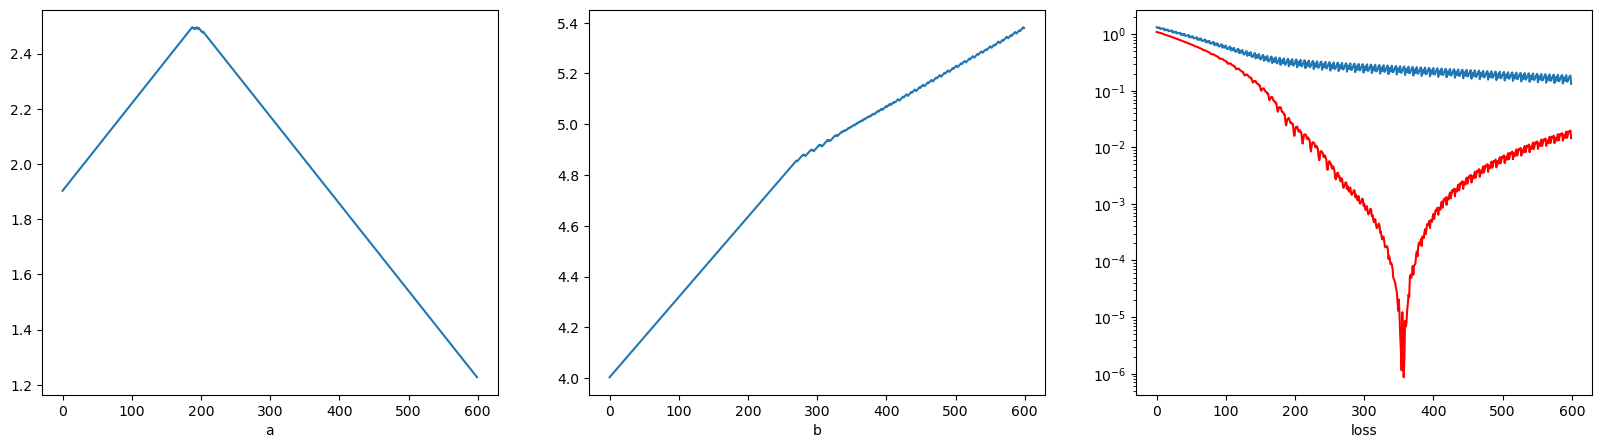

In [20]:
def plot_loss_ab(l, a, b):
    %matplotlib inline
    fig, ax = plt.subplots(1,3, figsize=(20, 5))
    ax[0].plot(a)
    ax[1].plot(b)
    ax[2].plot(l)
    ax[2].plot(manual_losses, c='red')
    
    ax[0].set_xlabel('a')
    ax[1].set_xlabel('b')
    ax[2].set_xlabel('loss')
    
    ax[2].set_yscale('log')
plot_loss_ab(losses, as_pred, bs_pred)

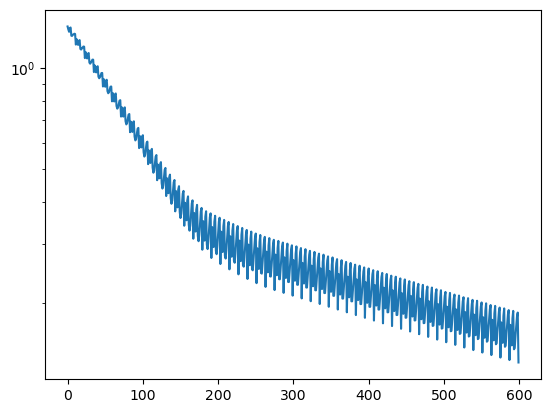

In [16]:
plt.plot(np.arange(len(losses)), losses)
plt.yscale('log')

### Test the model:



In [17]:
x_tests = xs[nb_batch_train*batch_size+1:]
y_pred = model(x_tests)

In [18]:
print(model.weights[0].numpy()[0][0])
print(model.weights[1].numpy()[0])

1.2275949
5.379193


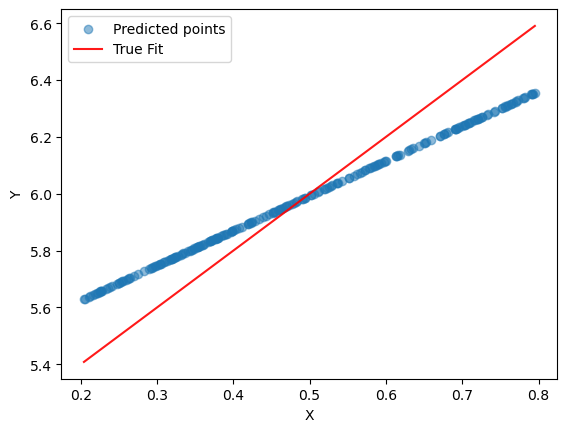

In [19]:
plt.scatter(x_tests, y_pred, alpha=0.5, label='Predicted points')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot([np.min(x_tests), np.max(x_tests)], [a*np.min(x_tests)+b, a*np.max(x_tests)+b], alpha=0.9, label='True Fit', color='red')
plt.legend()
# plt.title('Training data')